# Optimization

In this notebook, we'll use more advanced optimization methods that can speed up learning and perhaps even get a better final value for the cost function.

## Organization of this Notebook 
    1. Packages
    2. Mini-batch Gradient descent
    3. Adam method
    4. Construct the model

## 1 - Packages ##

In [16]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
from L_NN import *
from py_utils import load_dataset # Copy/pasted loader

%matplotlib inline

## 2 - Mini-batch Gradient descent ##

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y).
- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size`. The number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller.

Here is an example with `mini_batch_size = 64`:
<img src="images/partition.png" style="height:300px;">

In [2]:
def random_mini_batches(X, Y, mini_batch_size = 64):

    m = X.shape[1]
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # End case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 3 - Adam method ##

Adam method combines ideas from RMSprop and Momentum:

$$v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial J}{ \partial W^{[l]} }\tag{1}$$
$$v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t}\tag{2}$$

$$s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial J}{\partial W^{[l]} })^2\tag{3}$$
$$s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t}\tag{4}$$

$$W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}\tag{5}$$

Where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

In [3]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 3
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s

In [4]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 3
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]
        
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - pow(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - pow(beta1,t))

        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * np.square(grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * np.square(grads["db" + str(l+1)])
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - pow(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - pow(beta2,t))
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters, v, s

## 4 - Construct the model ##

In [24]:
def model_adam(X, Y, layers_dims, actFunctions, learning_rate = 0.0007, mini_batch_size = 32, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 3000, print_cost = True):

    L = len(layers_dims)
    costs = []
    t = 0 # Adam counter
    
    # Initialize
    parameters = initialize(layers_dims, actFunctions)
    v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        minibatches = random_mini_batches(X, Y, mini_batch_size)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            Zs, As, AL = globalForwardPropagation(minibatch_X, parameters)

            cost = computeCost(AL, minibatch_Y)

            grads = globalBackwardPropagation(minibatch_Y, Zs, As, parameters)

            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
        
        if print_cost and i % 100 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
            
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [6]:
training_imgLoaded, training_label, testing_imgLoaded, testing_label, classes = load_dataset()

In [7]:
training_img = training_imgLoaded.reshape(training_imgLoaded.shape[0], -1).T / 255.
testing_img = testing_imgLoaded.reshape(testing_imgLoaded.shape[0], -1).T / 255.

In [8]:
print("Number of pixels: %i" %(training_img.shape[0]))
print("Number of training data: %i" %(training_img.shape[1]))

Number of pixels: 12288
Number of training data: 209


Cost after epoch 0: 0.659684
Cost after epoch 100: 0.214576
Cost after epoch 200: 0.134498
Cost after epoch 300: 0.080903
Cost after epoch 400: 0.058900
Cost after epoch 500: 0.030319
Cost after epoch 600: 0.034851
Cost after epoch 700: 0.026987
Cost after epoch 800: 0.025531
Cost after epoch 900: 0.016476
Cost after epoch 1000: 0.012604
Cost after epoch 1100: 0.015553
Cost after epoch 1200: 0.007547
Cost after epoch 1300: 0.008164
Cost after epoch 1400: 0.001838
Cost after epoch 1500: 0.003502
Cost after epoch 1600: 0.002175
Cost after epoch 1700: 0.001273
Cost after epoch 1800: 0.000981
Cost after epoch 1900: 0.002030
Cost after epoch 2000: 0.000793
Cost after epoch 2100: 0.000609
Cost after epoch 2200: 0.001026
Cost after epoch 2300: 0.000598
Cost after epoch 2400: 0.000730
Cost after epoch 2500: 0.001159
Cost after epoch 2600: 0.000945
Cost after epoch 2700: 0.000868
Cost after epoch 2800: 0.000815
Cost after epoch 2900: 0.000206


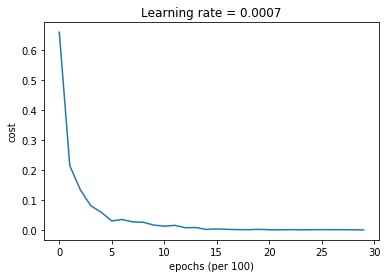

In [25]:
layers_dims = [12288, 20, 7, 5, 1]
actFunctions = ["ReLU", "ReLU", "ReLU", "sigmoid"]
parameters = model_adam(training_img, training_label, layers_dims, actFunctions)

TRAINING SET:
Accuracy: 1.000000
TESTING SET:
Accuracy: 0.720000


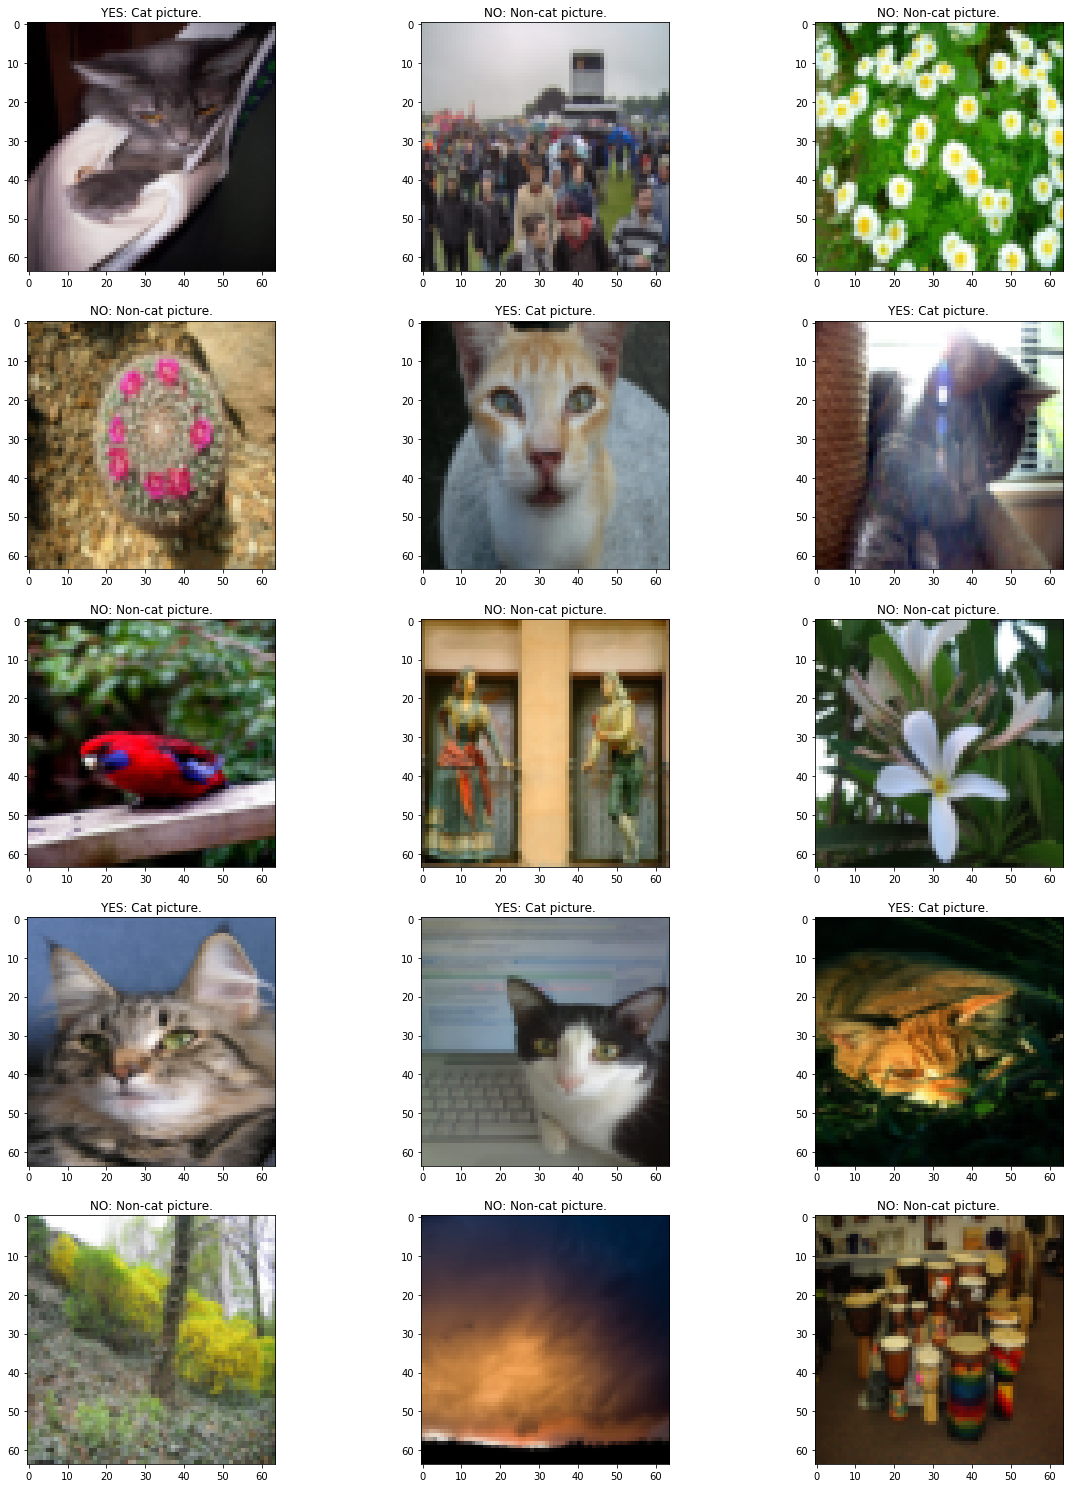

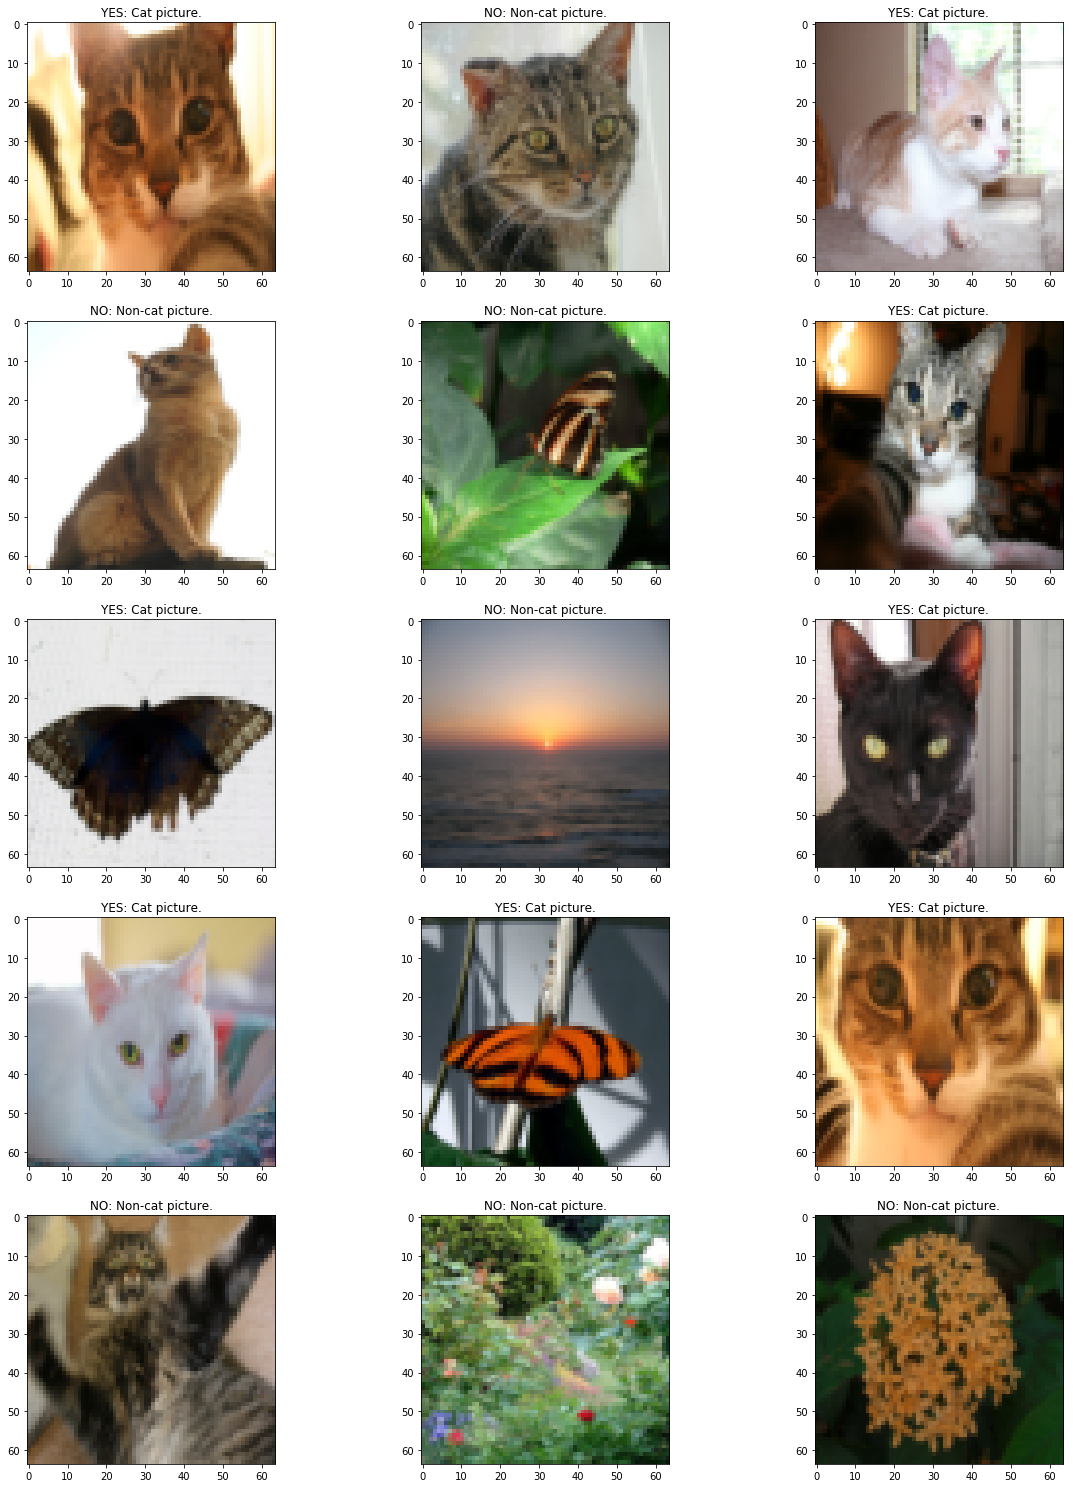

In [26]:
print("TRAINING SET:\nAccuracy: %f" %(visualize_decision(parameters, training_imgLoaded, training_label)))

print("TESTING SET:\nAccuracy: %f" %(visualize_decision(parameters, testing_imgLoaded, testing_label)))